<a href="https://colab.research.google.com/github/Build-Mate/FloorPlans-CNN-Classifier/blob/main/FloorPlans_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive First

In [1]:
from google.colab import drive
from google.colab import files
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
cd /content/drive/MyDrive/FloorPlans-CNN-Classifier

/content/drive/MyDrive/FloorPlans-CNN-Classifier


# 1. Install Dependencies and Setup

In [ ]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [9]:
import tensorflow as tf
import os

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [12]:
import cv2
import imghdr

In [19]:
data_dir = 'dataset'

In [15]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [21]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [22]:
import numpy as np
from matplotlib import pyplot as plt

In [24]:
data = tf.keras.utils.image_dataset_from_directory('dataset')

Found 5637 files belonging to 1 classes.


In [25]:
data_iterator = data.as_numpy_iterator()

In [26]:
batch = data_iterator.next()

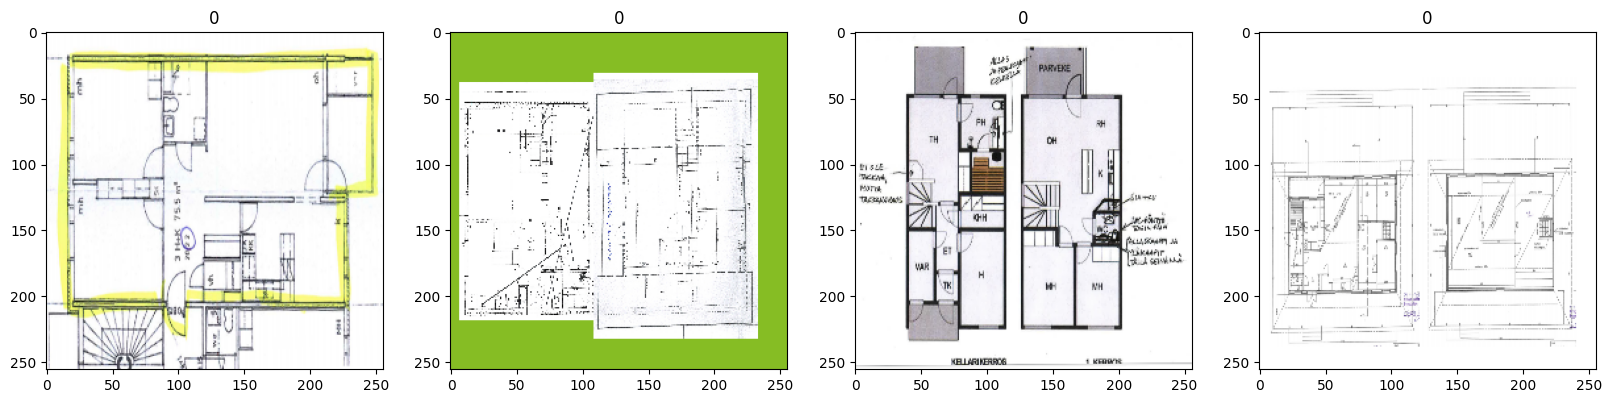

In [28]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [29]:
data = data.map(lambda x,y: (x/255, y))

In [30]:
data.as_numpy_iterator().next()

(array([[[[0.19607843, 0.21176471, 0.22352941],
          [0.19607843, 0.21176471, 0.22352941],
          [0.19607843, 0.21176471, 0.22352941],
          ...,
          [0.19607843, 0.21176471, 0.22352941],
          [0.19607843, 0.21176471, 0.22352941],
          [0.19607843, 0.21176471, 0.22352941]],
 
         [[0.7789905 , 0.7789905 , 0.7789905 ],
          [0.7789905 , 0.7789905 , 0.7789905 ],
          [0.7789905 , 0.7789905 , 0.7789905 ],
          ...,
          [0.7789905 , 0.7789905 , 0.7789905 ],
          [0.7789905 , 0.7789905 , 0.7789905 ],
          [0.7789905 , 0.7789905 , 0.7789905 ]],
 
         [[0.972526  , 0.972526  , 0.972526  ],
          [0.972526  , 0.972526  , 0.972526  ],
          [0.972526  , 0.972526  , 0.972526  ],
          ...,
          [0.972526  , 0.972526  , 0.972526  ],
          [0.972526  , 0.972526  , 0.972526  ],
          [0.972526  , 0.972526  , 0.972526  ]],
 
         ...,
 
         [[0.98301035, 0.98301035, 0.98301035],
          [0.89680

# 5. Split Data

In [31]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [32]:
train_size

123

In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [34]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [36]:
model = Sequential()

In [37]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [41]:
logdir='logs'

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [43]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
123/123 [==============================] - 137s 991ms/step - loss: 0.0079 - accuracy: 0.9919 - val_loss: 2.0699e-18 - val_accuracy: 1.0000
Epoch 2/20
123/123 [==============================] - 140s 1s/step - loss: 3.2355e-18 - accuracy: 1.0000 - val_loss: 2.9427e-19 - val_accuracy: 1.0000
Epoch 3/20
123/123 [==============================] - 139s 1s/step - loss: 3.2349e-18 - accuracy: 1.0000 - val_loss: 2.0697e-18 - val_accuracy: 1.0000
Epoch 4/20
123/123 [==============================] - 139s 1s/step - loss: 3.2352e-18 - accuracy: 1.0000 - val_loss: 2.8818e-19 - val_accuracy: 1.0000
Epoch 5/20
123/123 [==============================] - 139s 1s/step - loss: 3.2356e-18 - accuracy: 1.0000 - val_loss: 2.0700e-18 - val_accuracy: 1.0000
Epoch 6/20
123/123 [==============================] - 140s 1s/step - loss: 3.2357e-18 - accuracy: 1.0000 - val_loss: 1.8706e-18 - val_accuracy: 1.0000
Epoch 7/20
123/123 [==============================] - 141s 1s/step - loss: 3.2354e-18 - accurac

# 8. Plot Performance

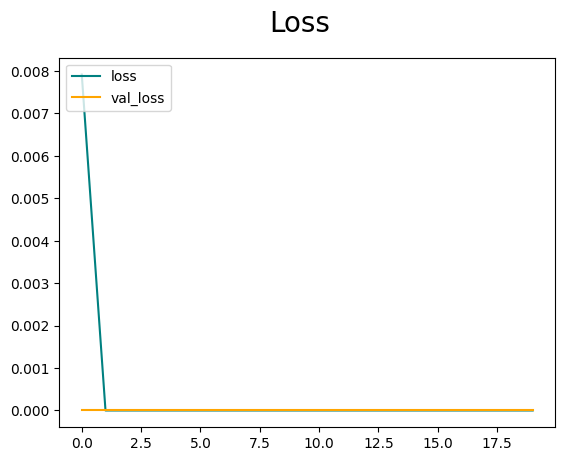

In [44]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

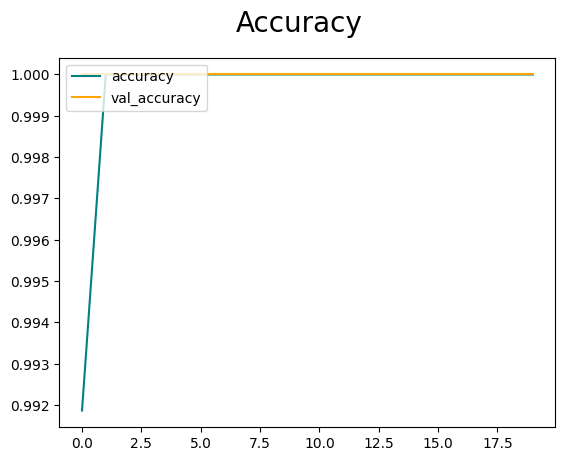

In [45]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [46]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 32ms/step


In [49]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [53]:
import cv2

In [73]:
!ls

dataset  devs.png  logs  models  test.png


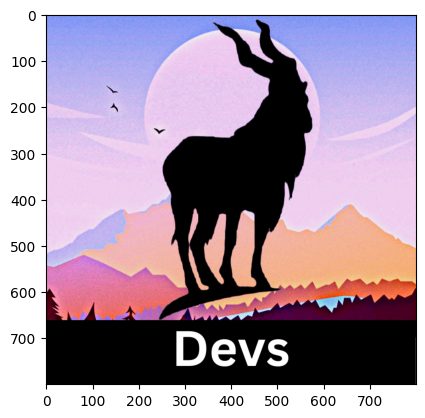

In [74]:
img = cv2.imread('devs.png')
plt.imshow(img)
plt.show()

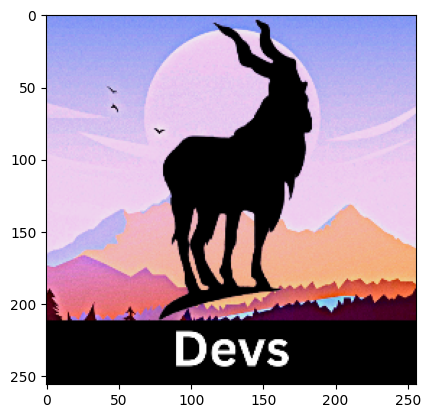

In [75]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [76]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 21ms/step


In [77]:
yhat

array([[8.12786e-17]], dtype=float32)

In [78]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [63]:
from tensorflow.keras.models import load_model

In [64]:
model.save(os.path.join('models','imageclassifier.h5'))

In [66]:
new_model = load_model('models/imageclassifier.h5')

In [79]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 97ms/step


array([[8.12786e-17]], dtype=float32)